In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import crystalball
from matplotlib import cm


from stripROtools import colors
from stripROtools import GetTransErrs
from stripROtools import Mismeasurment_vs_z
from stripROtools import random_three_vector
from stripROtools import plot_track

In [79]:
# Solid angle range in theta [degrees]
theta_min = 15
theta_max = 30



# Read dE/dx data from SRIM

In [80]:
# Load dEdx data simulated with SRIM
dEdx_data = np.loadtxt("./data/srim_po210_heco2.txt",skiprows=4)

dEdx_data = dEdx_data.T

# convert from angstrom to cm
dEdx_data[0] = dEdx_data[0]*1e-8

#dEdx resolution as seen in dEdx_data[0] 
delta_x = 0.1

# convert to eV/cm
dEdx_data[1] = dEdx_data[1]/1e-8
dEdx_data[2] = dEdx_data[2]/1e-8

dEdx = dEdx_data[1] + dEdx_data[2]




Text(0, 0.5, 'dE/dx [eV/cm] ')

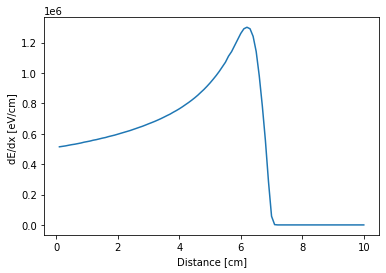

In [81]:
plt.plot(dEdx_data[0],dEdx)
plt.xlabel("Distance [cm]")
plt.ylabel("dE/dx [eV/cm] ")


# Simulate Po210 alpha tracks

In [82]:
# The paramters, in order, are:
# number of simulations
# minimum angle to vertical [degrees] - this is based  on requiring a min. of 5 hits
# maximum angle to vertical [degrees]
# drfit length [cm]
# Apply diffusion T/F
# Transverse diffusion coefficent from Magboltz [cm/sqrt(cm)]
# W-value as obtained using degrad

def sim_p210(n_sims = 100, theta_min = theta_min, theta_max = theta_max, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2):

    tracks = pd.DataFrame(columns = ['direction', 'start', 'track'])

    for i in range(n_sims):

        # draw a random direction within specified solid angle (pointing down towards the readout plane)
        v = random_three_vector(theta_min,theta_max)

        # Maximumm track length of alpha track
        L_max = -DL/v[2]

        # Length segments we will distribute charge on, 0.1 is the resolution of length of the SRIM simulation
        L_segments = np.arange(0,L_max+0.1,0.1)

        # Edges of the length segments we will distribute charge on (all edges are listed)
        L_edges = np.append(L_segments,L_max)

        # Energy deposited in each segment given dEdx (energy in each bin is listed)
        E_segments = dEdx[0:len(L_segments)]*np.diff(L_edges)

        # Compute corresponding number of ionizaed eletrons using energy deposited per segment divided by W-value
        Ne_segments = np.round(E_segments/W).astype("int")

        #find left and right edges for each bin
        Left_edges = L_segments[0:-1]
        Right_edges = L_segments[1:]

        track = np.empty((0,3))

        for N,left_edge,right_edge in zip(Ne_segments,Left_edges,Right_edges):

            Ts = np.random.uniform(low=left_edge,high=right_edge,size=N)

            if Diff == False:

                x_vals = Ts*v[0]
                y_vals = Ts*v[1]
                z_vals = DL + Ts*v[2]

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)
            
            elif Diff == True:

                z_vals = DL + Ts*v[2]

                x_vals = Ts*v[0] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                y_vals = Ts*v[1] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                z_vals = z_vals + DLong*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)

        x_rand = np.random.uniform()-0.5
        y_rand = np.random.uniform()-0.5

        track[:,0] = track[:,0]+x_rand # randomize x position (1 cm random uniform dist)
        track[:,1] = track[:,1]+y_rand # randomize x position (1 cm random uniform dist)

        tracks = tracks.append({'direction' : v, 'start' : np.array([x_rand,y_rand,DL]), 'track' : track }, ignore_index = True)

    return tracks




In [83]:
# Example of track simulation
tracks = sim_p210(n_sims = 100)
tracks.head()

,direction,start,track
0,"[-0.30822433644603336, -0.10710267881842908, -...","[0.24456102625373677, 0.24624122856039876, 1.2]","[[0.2155476326084073, 0.2328784966208896, 1.13..."
1,"[0.16448397945174492, -0.35967286422820743, -0...","[-0.311836339086522, -0.3099959342397609, 1.2]","[[-0.2814778479066214, -0.3398230566107262, 1...."
2,"[-0.10526625897652302, 0.23752874777249688, -0...","[-0.10745031129357518, -0.3207647125677634, 1.2]","[[-0.09772094365000569, -0.3130762643256785, 1..."
3,"[0.002417889962487603, 0.48816956357988517, -0...","[0.025516341356383254, 0.4201496212477459, 1.2]","[[0.002564096192047959, 0.4411857470022669, 1...."
4,"[0.4036891030830332, 0.04847188814096517, -0.9...","[-0.4935331400569364, 0.3512594235589853, 1.2]","[[-0.4532851268993334, 0.33571471343873555, 1...."


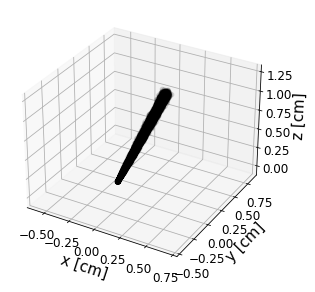

In [84]:
# Plot a Track
index = 0
track = tracks.iloc[index]["track"]
plot_track(track)

# Simulate readout


In [85]:
# the parameters, in order, are:
# peaking time [ns]
# digitization time [ns] 
# pitch of the x strips [um]
# pitch of the y strips [um]
# Threshold of x strips [No. electrons]
# Threshold of y strips [No. electrons]
# Charge sharing [lower strips / upper strips]
# Gain - extrapolating from PHA curve
# drift speed cm/ns
# Include charge integration effect.
# z resolution in cm, must be specified if Charge_integration = False
# Electronic gain in x [mV/fC]
# Electronic gain in y [mV/fC]

def sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = 200, pitch_y = 200,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = 0.41, Gain = 604, v_drift = 0.0008, Charge_integration = True, DL = 1.2, pitch_z = 0.02, G_x = 9.0, G_y = 4.5):

    #convert pitch to cm
    pitch_x = pitch_x * 1e-4
    pitch_y = pitch_y * 1e-4
    
    # Readout is 10 cm x 10 cm
    x_bins = np.arange(-5,5,pitch_x)
    y_bins = np.arange(-5,5,pitch_y)

    # Find strip edges in x and y
    Left_edges_x = x_bins[0:-1]
    Right_edges_x = x_bins[1:]
    Left_edges_y = y_bins[0:-1]
    Right_edges_y = y_bins[1:]


    hits = pd.DataFrame(columns = ['strips_x', 'strips_y', 'times_x', 'times_y','electrons_x','electrons_y'])

    for index, row in tracks.iterrows():

        track = row.track

        x_positions = []
        x_charges = []
        x_times = []
        adcs0 = []
        strips0 = []

        for L_edge,R_edge in zip(Left_edges_x,Right_edges_x):

            # Bin track over specific strip in x
            T_track = track[(track[:,0]> L_edge) &  (track[:,0]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):


                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) *Gain * CS / (CS+1.0)

                    if charge_detected > thres_x:
                        
                        # obtain mean time for the hit
                        x_times += [mean_time]
                        # obtain position of the hit
                        x_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips0 += [np.where(x_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        x_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs0 += [min( charge_detected/6241.5*G_x, 1023.0 ) ]

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,DL+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist *Gain * CS / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_x]
                    charge_detected = charge_detected [charge_detected>thres_x]


                    x_times += list(bin_centers/v_drift)
                    x_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    x_charges += list(charge_detected)

        

        y_positions = []
        y_charges = []
        y_times = []
        adcs1 = []
        strips1 = []

        for L_edge,R_edge in zip(Left_edges_y,Right_edges_y):

            # Bin track over specific strip in x
            T_track = track[(track[:,1]> L_edge) &  (track[:,1]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):

                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) * Gain / (CS+1.0)

                    if charge_detected > thres_y:

                        # obtain mean time for the hit
                        y_times += [mean_time]
                        # obtain position of the hit
                        y_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips1 += [np.where(y_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        y_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs1 += [ min( charge_detected/6241.5*G_y, 1023.0 ) ] # The min imposes saturation of ADC scale

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,DL+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist * Gain / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_y]
                    charge_detected = charge_detected [charge_detected>thres_y]


                    y_times += list(bin_centers/v_drift)
                    y_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    y_charges += list(charge_detected)

        hits = hits.append({'strips_x' : np.array(x_positions), 'strips0' : np.array(strips0),  'strips_y' : np.array(y_positions), 'strips1' : np.array(strips1), 'times_x' : np.array(x_times), 'times0' : np.array(x_times), 'times_y' : np.array(y_times), 'times1' : np.array(y_times), 'electrons_x' :  np.array(x_charges), 'adcs0' :  np.array(adcs0), 'electrons_y' : np.array(y_charges), 'adcs1' :  np.array(adcs1) }, ignore_index = True)
        
    return hits


In [86]:
# Example of readout simulation
hits = sim_readout(tracks)
tracks = pd.concat([tracks,hits],axis=1)
tracks.head()


,direction,start,track,strips_x,strips_y,times_x,times_y,electrons_x,electrons_y,adcs0,adcs1,strips0,strips1,times0,times1
0,"[-0.30822433644603336, -0.10710267881842908, -...","[0.24456102625373677, 0.24624122856039876, 1.2]","[[0.2155476326084073, 0.2328784966208896, 1.13...","[-0.15000000000010338, -0.1300000000001038, -0...","[0.10999999999989107, 0.12999999999989065, 0.1...","[-3.5764396947236676, 67.36481772058286, 142.8...","[41.004827104810545, 164.18911377652202, 338.3...","[152447.8865248227, 174753.04964539007, 187222...","[838317.7304964539, 671253.9007092199, 395384....","[219.82391712303203, 251.98709393711619, 269.9...","[604.4107645972991, 483.96099546447, 285.06445...","[242, 243, 244, 245, 246, 247, 248, 249, 250, ...","[255, 256, 257, 258, 259]","[-3.5764396947236676, 67.36481772058286, 142.8...","[41.004827104810545, 164.18911377652202, 338.3..."
1,"[0.16448397945174492, -0.35967286422820743, -0...","[-0.311836339086522, -0.3099959342397609, 1.2]","[[-0.2814778479066214, -0.3398230566107262, 1....","[-0.2700000000001008, -0.23000000000010168, -0...","[-0.8100000000000893, -0.7900000000000897, -0....","[1080.568440192896, 820.2638853564309, 694.191...","[-84.70304885968429, -33.29318777704199, 32.70...","[64105.39007092198, 78331.51773049645, 87113.0...","[242885.10638297873, 395812.7659574468, 394956...","[92.4374766703994, 112.95099889040584, 125.613...","[175.11543358542087, 285.3732991762414, 284.75...","[236, 238, 239, 240, 241, 242, 243, 244, 245]","[209, 210, 211, 212, 213, 214, 215, 216, 217, ...","[1080.568440192896, 820.2638853564309, 694.191...","[-84.70304885968429, -33.29318777704199, 32.70..."
2,"[-0.10526625897652302, 0.23752874777249688, -0...","[-0.10745031129357518, -0.3207647125677634, 1.2]","[[-0.09772094365000569, -0.3130762643256785, 1...","[-0.25000000000010125, -0.23000000000010168, -...","[-0.33000000000009955, -0.3100000000001, -0.27...","[-41.09266436903575, 48.081300163412564, 237.2...","[1446.721412414154, 1356.6438493840117, 1145.3...","[101514.83687943262, 352316.1985815603, 188627...","[143931.91489361704, 154641.13475177306, 13108...","[146.3804425081941, 508.02624164608545, 271.99...","[103.77210879136052, 111.49324783833674, 94.50...","[237, 238, 239, 240]","[233, 234, 236, 237, 238, 239, 240, 241, 242, ...","[-41.09266436903575, 48.081300163412564, 237.2...","[1446.721412414154, 1356.6438493840117, 1145.3..."
3,"[0.002417889962487603, 0.48816956357988517, -0...","[0.025516341356383254, 0.4201496212477459, 1.2]","[[0.002564096192047959, 0.4411857470022669, 1....",[0.02999999999989278],"[0.42999999999988425, 0.4499999999998838, 0.46...",[69.14528116848894],"[1460.4679805748488, 1432.9126228698597, 1382....",[491416.1134751773],"[185912.05673758866, 250167.37588652482, 25487...",[708.6029033528151],"[134.03897385550732, 180.3658081373647, 183.76...",[251],"[271, 272, 273, 274, 275, 276, 277, 278, 279, ...",[69.14528116848894],"[1460.4679805748488, 1432.9126228698597, 1382...."
4,"[0.4036891030830332, 0.04847188814096517, -0.9...","[-0.4935331400569364, 0.3512594235589853, 1.2]","[[-0.4532851268993334, 0.33571471343873555, 1....","[-0.49000000000009614, -0.47000000000009656, -...","[0.3899999999998851, 0.4099999999998847, 0.429...","[1462.1969668737534, 1423.48381313564, 1369.89...","[241.95845713941833, 3.987840414290659, -72.84...","[70955.00709219859, 106783.77304964539, 116794...","[166635.4609929078, 1053787.2340425532, 114374...","[102.31435773929141, 153.97804333041873, 168.4...","[120.14092357095011, 759.7600822224608, 82.461...","[225, 226, 227, 228, 229, 230, 231, 232, 233, ...","[269, 270, 271]","[1462.1969668737534, 1423.48381313564, 1369.89...","[241.95845713941833, 3.987840414290659, -72.84..."


# Perform 3D Reconstruction

[   9.77017849   85.64320291  163.48975542  241.48964629  319.57908716
  396.0833292   473.53650324  548.40991313  625.22270223  702.15135654
  775.45010375  852.84368553  913.5093978   997.02434216 1078.83459028
 1143.41368376 1218.02132015 1287.71779848 1381.49453169 1444.18319488]


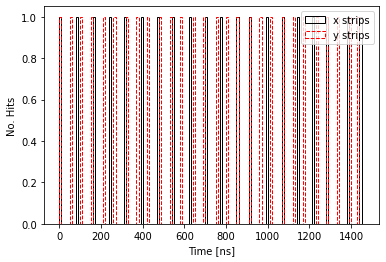

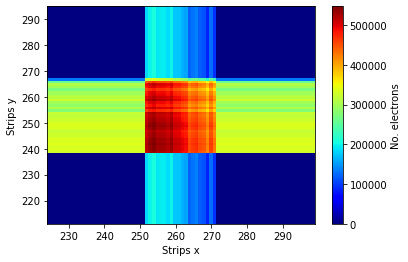

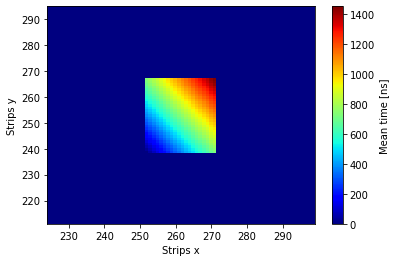

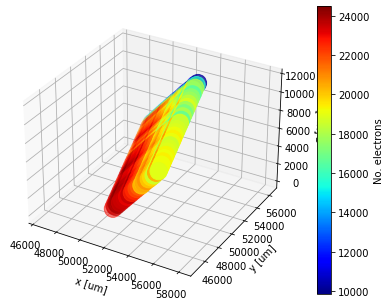

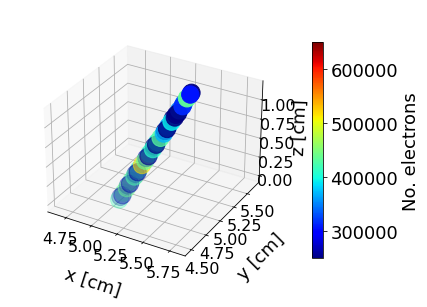

In [112]:
# 3D clustering paramters
mu = -6.684141
sigma = 16.382493
n_sigma = 3

# Look at a single event after the cut
test_event = tracks.iloc[13]
# Make a TrackTools object for the event
dsp = stripROtools.TrackTools(event = test_event, Mult_factor = 1.0, gain_x=9, gain_y=4.5, v_drift=8.0)

# Plot 1D time display
dsp.TimeHistView( t_bin =10)

# Plot 2D displays of charge and time
dsp.Strip2DView(fullview = False)
dsp.Strip2DView_times(fullview = False)

# Plot 3D displays
dsp.Reconst3D_v0()
x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma,save_name = "sim_alpha")

# Make voxel plot

In [113]:
# Get principal axis and center of charge
z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)

In [114]:
def make_voxel_plot(x,y,z,c,v_PA,x_b,save_name):

    # Find initial t parameter to draw principal axis
    ti = -x_b[2]/v_PA[2]

    # Find final parameter to draw principal axis
    tf=(np.max(z)-x_b[2])/v_PA[2]

    # Start and stop point of fitted line
    start = x_b + (ti*v_PA)
    stop = x_b + (tf*v_PA)

    # transform coord
    xi = (start[0]-np.min(x))/200 
    yi = (start[1]-np.min(y))/200
    zi = (start[2]-np.min(z))/200

    xf = (stop[0]-np.min(x))/200 
    yf = (stop[1]-np.min(y))/200
    zf = (stop[2]-np.min(z))/200

    x = np.round((x-np.min(x))/200).astype(int)
    y = np.round((y-np.min(y))/200).astype(int)
    z = np.round((z-np.min(z))/200).astype(int)

    # Empty array to store tensor
    tensor = np.zeros(shape=(np.max(x)+1,np.max(y)+1,np.max(z)+1))

    # Loop through track and update tensor
    for xj, yj, zj, cj in zip(x,y,z,c):

        tensor[xj][yj][zj] = cj

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('x strip',labelpad = 40,fontsize=25)
    ax.set_ylabel('y strip',labelpad = 40,fontsize=25)
    ax.set_zlabel('z bin',labelpad = 40,fontsize=25)
    ax.tick_params(labelsize=20)
    ax.tick_params(direction='out', pad=20)
    ax.set_box_aspect(None, zoom=0.85)


    cmap = plt.get_cmap("viridis")
    norm= plt.Normalize(0.0, 700000)


    ax.voxels(tensor,facecolors=cmap(norm(tensor)),alpha=1)

    ax.plot([xi,xf], [yi,yf], [zi,zf], color='k')

    m = cm.ScalarMappable(cmap=cmap, norm=norm)
    m.set_array([])
    cbar = plt.colorbar(m,fraction=0.03, pad=0.07)
    cbar.set_label(label='No. electrons',size=25)
    cbar.ax.tick_params(labelsize=20)

    stripROtools.set_axes_equal(ax)
    plt.tight_layout()
    plt.savefig("./figures/"+save_name+".pdf")




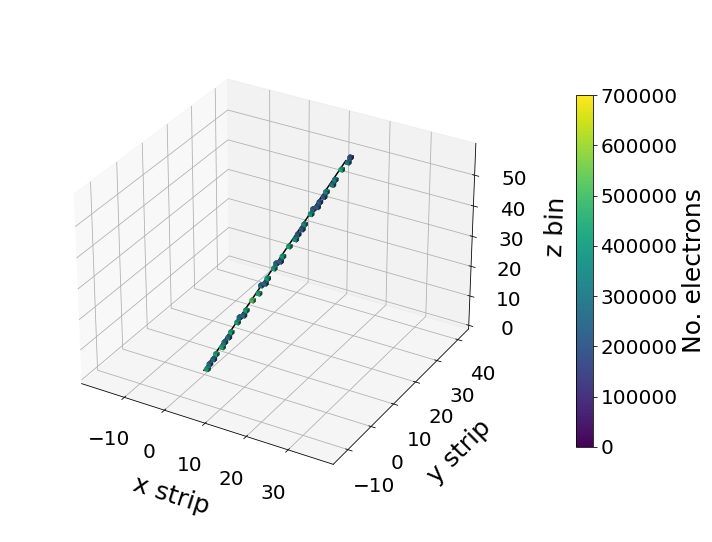

In [115]:
make_voxel_plot(x,y,z,c,v_PA,x_b,"sim_alpha")

# Now plot real alpha